# Momentum Strategies
<p class="lead">This script replicates the methodology of Jegadeesh and Titman (JF, 1993). The script is designed to create momentum portfolios based on past 3 to 12 month returns.</p>

## Background
One of the first studies to document the momentum effect was written by Jegadeesh and Titman (JF, 1993) who show that stocks experiencing a price run-up in the past three to twelve months continue to experience positive returns in the subsequent three to twelve months. A similar pattern was documented for stocks that experienced negative returns in the past three to twelve months.

## Momentum Strategies
While Jegadeesh and Titman (2001) algorithm is more recent and controls for return reversals, the script below replicates the methodology of the original Jegadeesh and Titman (JF, 1993), which is the first study to provide a throrough investigation of the momentum effect. The script first creates momentum portfolios based on past 3 to 12 month returns. The portfolios are then held for 3 to 12 months and their performance evaluated to provide comparisons between high momentum versus low momentum stocks.

This script follows the same procedure for calculating momentum portfolios as Jegadeesh and Titman's (2003) Table 1, with only one difference: Monthly returns are extracted directly from CRSP Monthly Stock File (MSF) instead of compounding daily returns into monthly figures. The code can be easily modified to compute Momentum Portfolios with monthly returns compounded from CRSP Daily Stock File. The program creates equally weighted portfolios for all NYSE and AMEX common stock securities in CRSP based on deciles created on previous three to 12 month returns. Portfolios are rebalanced every month and are held for 3 to 12 months. Average monthly returns for the momentum portfolios are computed.

This code does a good job replicating the results included in Table 1 of Jegadessh and Titman (1993). For example, for the case of momentum portfolios that were created using the last 6 months of returns and held by 6 months (J=6 and K=6), our code produces winner's monthly average return of 1.71% (T=4.22), losers' monthly average return of 0.80% (T=1.59) and long-short monthly average return of 0.91 (T=3.01). These results are very close than the ones presented by Jegadessh and Titman's Table 1: winner's monthly average return of 1.74% (T=4.33), losers' monthly average return of 0.79% (T=1.56) and long-short monthly average return of 0.95 (T=3.07).

In [ ]:
################################################
# Jegadeesh & Titman (1993) Momentum Portfolio #
# Sep 2019                                     #  
################################################

import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #
###################
conn=wrds.Connection()

###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
# added exchcd=-2,-1,0 to address the issue that stocks temp stopped trading
# without exchcd=-2,-1, 0 the non-trading months will be tossed out in the output
# leading to wrong cumret calculation in momentum step
# Code	Definition
# -2	Halted by the NYSE or AMEX
# -1	Suspended by the NYSE, AMEX, or NASDAQ
# 0	Not Trading on NYSE, AMEX, or NASDAQ
# 1	New York Stock Exchange
# 2	American Stock Exchange

crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, b.ncusip, a.date, 
                      b.shrcd, b.exchcd, b.siccd,
                      a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1963' and '12/31/1989'
                      and b.exchcd between -2 and 2
                      and b.shrcd between 10 and 11
                      """) 

# Change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=\
    crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])

#######################################################
# Create Momentum Portfolio                           #   
# Measures Based on Past (J) Month Compounded Returns #
#######################################################

J = 6 # Formation Period Length: J can be between 3 to 12 months
K = 6 # Holding Period Length: K can be between 3 to 12 months

_tmp_crsp = crsp_m[['permno','date','ret']].sort_values(['permno','date'])\
    .set_index('date')

# Replace missing return with 0
_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)

# Calculate rolling cumulative return
# by summing log(1+ret) over the formation period
_tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])
umd = _tmp_crsp.groupby(['permno'])['logret'].rolling(J, min_periods=J).sum()
umd = umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1


########################################
# Formation of 10 Momentum Portfolios  #
########################################

# For each date: assign ranking 1-10 based on cumret
# 1=lowest 10=highest cumret
umd=umd.dropna(axis=0, subset=['cumret'])
umd['momr']=umd.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))

umd.momr=umd.momr.astype(int)
umd['momr'] = umd['momr']+1

# Corrected previous version month end line up issue
# First lineup date to month end date medate
# Then calculate hdate1 and hdate2 using medate

umd['form_date'] = umd['date']
umd['medate'] = umd['date']+MonthEnd(0)
umd['hdate1']=umd['medate']+MonthBegin(1)
umd['hdate2']=umd['medate']+MonthEnd(K)
umd = umd[['permno', 'form_date','momr','hdate1','hdate2']]

# join rank and return data together
# note: this step consumes a lot of memory so takes a while
_tmp_ret = crsp_m[['permno','date','ret']]
port = pd.merge(_tmp_ret, umd, on=['permno'], how='inner')
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]

umd2 = port.sort_values(by=['date','momr','form_date','permno']).drop_duplicates()
umd3 = umd2.groupby(['date','momr','form_date'])['ret'].mean().reset_index()

# Skip first two years of the sample 
start_yr = umd3['date'].dt.year.min()+2
umd3 = umd3[umd3['date'].dt.year>=start_yr]
umd3 = umd3.sort_values(by=['date','momr'])

# Create one return series per MOM group every month
ewret = umd3.groupby(['date','momr'])['ret'].mean().reset_index()
ewstd = umd3.groupby(['date','momr'])['ret'].std().reset_index()
ewret = ewret.rename(columns={'ret':'ewret'})
ewstd = ewstd.rename(columns={'ret':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','momr'], how='inner')
ewretdat = ewretdat.sort_values(by=['momr'])

# portfolio summary
ewretdat.groupby(['momr'])['ewret'].describe()[['count','mean', 'std']]

#################################
# Long-Short Portfolio Returns  #
#################################

# Transpose portfolio layout to have columns as portfolio returns
ewretdat2 = ewretdat.pivot(index='date', columns='momr', values='ewret')

# Add prefix port in front of each column
ewretdat2 = ewretdat2.add_prefix('port')
ewretdat2 = ewretdat2.rename(columns={'port1':'losers', 'port10':'winners'})
ewretdat2['long_short'] = ewretdat2['winners'] - ewretdat2['losers']

# Compute Long-Short Portfolio Cumulative Returns
ewretdat3 = ewretdat2
ewretdat3['1+losers']=1+ewretdat3['losers']
ewretdat3['1+winners']=1+ewretdat3['winners']
ewretdat3['1+ls'] = 1+ewretdat3['long_short']

ewretdat3['cumret_winners']=ewretdat3['1+winners'].cumprod()-1
ewretdat3['cumret_losers']=ewretdat3['1+losers'].cumprod()-1
ewretdat3['cumret_long_short']=ewretdat3['1+ls'].cumprod()-1

#################################
# Portfolio Summary Statistics  #
################################# 

# Mean 
mom_mean = ewretdat3[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewretdat3['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewretdat3['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewretdat3['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')

Loading library list...
Done


## Outcome Discussion
We report below the mean and standard deviation of the 10 momentum portfolios:

<table class="table table-striped table-hover table-bordered table-mobile tablesorter tablesorter-default">
    
    <tbody>
    
        <tr>
            
                
                    <td>
                        
                            
                                momr
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                count
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                mean
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                std
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                1 (Losers)
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.85%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.087
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                2
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.16%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.070
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                3
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.29%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.065
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                4
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.29%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.061
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                5
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.34%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.059
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                6
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.39%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.057
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                7
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.40%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.057
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                8
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.46%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.058
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                9
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.55%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.062
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                10 (Winners)
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                300
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.69%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.070
                            
                        
                    </td>
                 
            
        </tr>
    
    </tbody>
</table>

The table below reports the detailed summary statistics for the winners, losers and long short portfolio (winners-losers):

<table class="table table-striped table-hover table-bordered table-mobile tablesorter tablesorter-default">
    
    <tbody>
    
        <tr>
            
                
                    <td>
                        
                            
                                momr
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                mean
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                t-stat
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                p-value
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                winners
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.69%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                4.20
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.0000
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                losers
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.85%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                1.69
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.0930
                            
                        
                    </td>
                 
            
        </tr>
    
        <tr>
            
                
                    <td>
                        
                            
                                long_short
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.84%
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                2.76
                            
                        
                    </td>
                 
            
                
                    <td>
                        
                            
                                0.0061
                            
                        
                    </td>
                 
            
        </tr>
    
    </tbody>
</table>

The figure below reports the cumulative returns of the winners and losers portfolio throughout the sample period. The blue line represents the cumulative returns of the winners portfolio (port10), and the red line shows the cumulative returns of the losers portfolio (port1).

In [16]:
ewretdat3.columns

Index(['losers', 'port2', 'port3', 'port4', 'port5', 'port6', 'port7', 'port8',
       'port9', 'winners', 'long_short', '1+losers', '1+winners', '1+ls',
       'cumret_winners', 'cumret_losers', 'cumret_long_short'],
      dtype='object', name='momr')

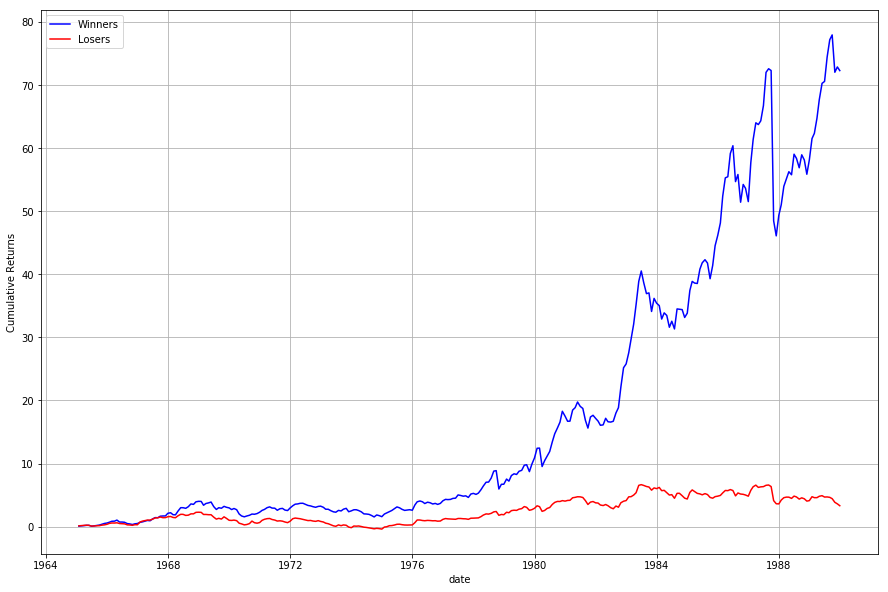

In [34]:
plt.figure(figsize=(15,10))
plt.plot(ewretdat3.cumret_winners, 'b', alpha=1)
plt.plot(ewretdat3.cumret_losers, 'r', alpha=1)
plt.xlabel('date')
plt.ylabel('Cumulative Returns')
plt.legend(['Winners', 'Losers'])
plt.grid(True)

We then show the cumulative returns of the long short momentum strategy, which is long winners (port10) and short losers (port1).

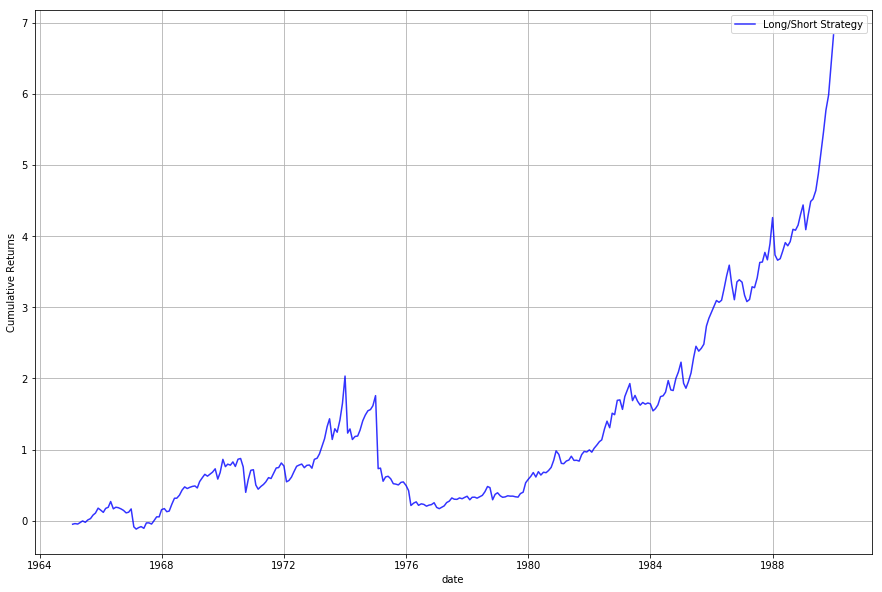

In [36]:
plt.figure(figsize=(15,10))
plt.plot(ewretdat3.cumret_long_short, 'b', alpha=0.8)
plt.xlabel('date')
plt.ylabel('Cumulative Returns')
plt.legend(['Long/Short Strategy'])
plt.grid(True)

However, when extending the time period beyond December 1989, the pattern of momentum profits becomes very volatility with sharp losses of the Long/Short strategy coinciding with business cycles. Jegadeesh and Titman (2001) provide relevant discussion on strong reversal and incorporate additional filters on included securities after adding Nasdaq stocks.

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(ewretdat3.cumret_long_short, 'b', alpha=0.8)
plt.xlabel('date')
plt.ylabel('Cumulative Returns')
plt.legend(['Long/Short Strategy'])
plt.grid(True)

## References
Brennan, Michael J., Narasimhan Jegadeesh, and Bhaskaran Swaminathan, 1993, "Investment Analysis and the Adjustment of Stock Prices to Common Information," Review of Financial Studies 6, pp. 799-824.

Chan, K., A. Hameed, and W. Tong, 2000, "Profitability of momentum strategies in international equity markets," Journal of Financial and Quantitative Analysis 35, pp 153- 172

Chan, Louis K. C., Narasimhan Jegadeesh, and Josef Lakonishok, 1996, "Momentum strategies," Journal of Finance 51, pp 1681-1713.

Chui, Andy, Sheridan Titman and K.C. John Wei, 2000, Momentum, ownership structure, and financial crises: An analysis of Asian stock markets, working paper, University of Texas at Austin.

Daniel , Kent , David Hirshleifer, and Avanidhar Subrahmanyam, 1998, "Investor Psychology and Security Market Under-and Overreactions," Journal of Finance 53, pp 1839-1886.

DeLong, J. Bradford, Andrei Shleifer, Lawrence H. Summers, and Robert J. Waldmann, 1990, "Positive feedback investment strategies and destabilizing rational speculation," Journal of Finance 45, pp 379-395.

Fama, Eugene, and Kenneth French, 1996, "Multifactor Explanations of Asset Pricing Anomalies," Journal of Financial Economics pp 51, pp 55-84.

Grundy, Bruce D. and Spencer J. Martin, 2001, "Understanding the Nature of Risks and the Sources of Rewards to Momentum Investing," Review of Financial Studies 14, pp 29- 78.

Gutierrez, R., M. Cooper, and A. Hameed, 2004, Market states and Momentum, Journal of Finance (forthcoming)

Hong, H., and J. Stein, 1999, "A Unified Theory of Underreaction, Momentum Trading and Overreaction in Asset Markets," Journal of Finance 54, pp 2143-2184.

Hong, Harrison, Terence Lim and Jeremy C. Stein, 2000, Bad news travels slowly: Size, analyst coverage, and the profitability of momentum strategies, Journal of Finance 55, 265-295.

Jegadeesh, Narasimhan, 1990, "Evidence of Predictable Behavior of Security Returns," Journal of Finance 45, pp 881-898.

Jegadeesh, N., & Titman, S. (1993). Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency. The Journal of Finance, 48(1), 65-91.

Jegadeesh, Narasimhan, and Sheridan Titman, 1995, "Overreaction, Delayed Reaction and Contrarian Profits," Review of Financial Studies 8, pp 973-993.

Jegadeesh, Narasimhan, and Sheridan Titman, 2001, "Profitability of momentum strategies: An evaluation of alternative explanations," Journal of Finance 56, pp 699-720.

Jegadeesh, Narasimhan, and Sheridan Titman, 2002, "Cross-Sectional and Time-Series Determinants of Momentum Returns," Review of Financial Studies 15, 143-157.

Korajczyk, R., and R. Sadka, 2004, Are Momentum Profits robust to trading costs?, Journal of Finance 59, 1039-1082.

Rouwenhorst, K. Geert, 1998, "International momentum strategies," Journal of Finance 53, pp 267-284.

Lee, Charles and Bhaskaran Swaminathan, 2000, "Price Momentum and Trading Volume," Journal of Finance 55, pp 1217-1269

Lesmond, D., M. Schill, and C. Zhou, 2003, The illusory nature of Momentum profits, Journal of Financial Economics 71, 349-380.

Lo, Andrew, and A. Craig MacKinlay, 1990, "When are Contrarian Profits Due to Stock Market Overreaction?" Review of Financial Studies 3, pp 175-208.

Moskowitz, Tobias J. and Grinblatt, Mark, 1999, "Does Industry Explain Momentum?" Journal of Finance 54, pp 1249-1290.